In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [3]:
# 1. Load data
df = pd.read_csv('insurance.csv')

# Приводим имена столбцов к нижнему регистру (на случай, если в файле они записаны в разных регистрах)
df.columns = df.columns.str.lower()

print("Dataset columns:", df.columns)

# Просмотр первых строк
print("First 5 rows of the dataset:")
print(df.head())

Dataset columns: Index(['age', 'sex', 'bmi', 'children', 'smoker', 'expenses'], dtype='object')
First 5 rows of the dataset:
   age  sex   bmi  children  smoker  expenses
0   19    0  27.9         0       1  16884.92
1   18    1  33.8         1       0   1725.55
2   28    1  33.0         3       0   4449.46
3   33    1  22.7         0       0  21984.47
4   32    1  28.9         0       0   3866.86


In [4]:
# Информация о датасете
print("\nDataset info:")
print(df.info())

# Статистика по числовым признакам
print("\nStatistics for numerical features:")
print(df.describe())




Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   expenses  1338 non-null   float64
dtypes: float64(2), int64(4)
memory usage: 62.8 KB
None

Statistics for numerical features:
               age          sex          bmi     children       smoker  \
count  1338.000000  1338.000000  1338.000000  1338.000000  1338.000000   
mean     39.207025     0.505232    30.665471     1.094918     0.204783   
std      14.049960     0.500160     6.098382     1.205493     0.403694   
min      18.000000     0.000000    16.000000     0.000000     0.000000   
25%      27.000000     0.000000    26.300000     0.000000     0.000000   
50%      39.000000     1.000000

In [5]:
# Проверка на пропуски
print("\nNumber of missing values per column:")
print(df.isnull().sum())



Number of missing values per column:
age         0
sex         0
bmi         0
children    0
smoker      0
expenses    0
dtype: int64


C:\Users\Timing\AppData\Local\Temp\ipykernel_20768\246815816.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")


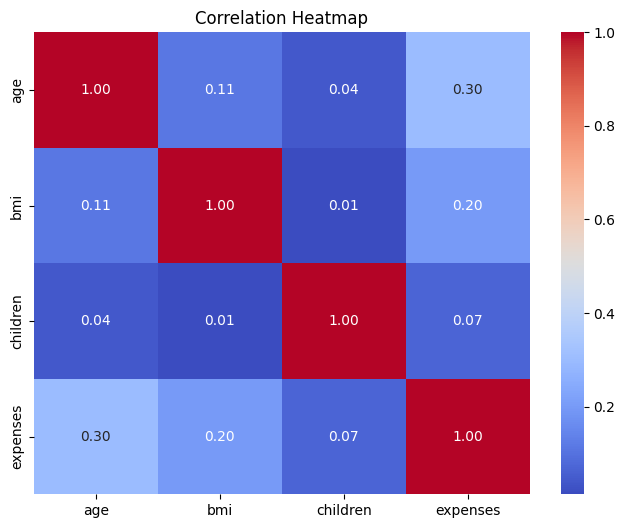

In [6]:
# Преобразуем категориальные признаки в тип category
df['sex'] = df['sex'].astype('category')
df['smoker'] = df['smoker'].astype('category')

# 2. Визуализация: корреляционная матрица
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



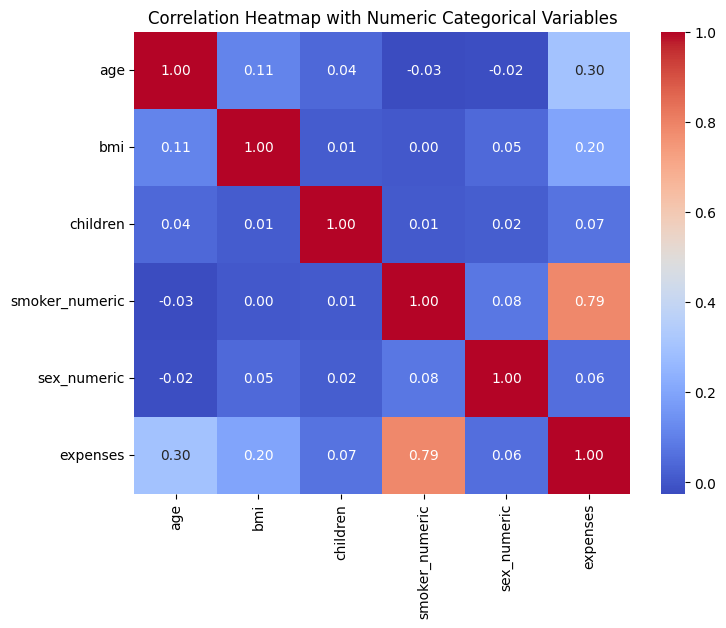

In [7]:
df['smoker_numeric'] = df['smoker'].cat.codes
df['sex_numeric'] = df['sex'].cat.codes
plt.figure(figsize=(8, 6))
sns.heatmap(df[['age', 'bmi', 'children', 'smoker_numeric', 'sex_numeric', 'expenses']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with Numeric Categorical Variables")
plt.show()


In [8]:
# 3. Подготовка данных

X = df.drop(columns=['expenses'])
y = df['expenses']


In [9]:
# Определяем числовые и категориальные признаки
numeric_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker']

# Создаем препроцессор: стандартизация для числовых признаков и one-hot encoding для категориальных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)



In [10]:
# 4. Разбиение на обучающую и тестовую выборки (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Определение моделей с использованием Pipeline
models = {
    'Linear Regression': Pipeline([
         ('preprocessor', preprocessor),
         ('regressor', LinearRegression())
    ]),
    'Decision Tree': Pipeline([
         ('preprocessor', preprocessor),
         ('regressor', DecisionTreeRegressor(random_state=42))
    ]),
    'Random Forest': Pipeline([
         ('preprocessor', preprocessor),
         ('regressor', RandomForestRegressor(random_state=42))
    ]),
    'SVR': Pipeline([
         ('preprocessor', preprocessor),
         ('regressor', SVR())
    ]),
    'Gradient Boosting': Pipeline([
         ('preprocessor', preprocessor),
         ('regressor', GradientBoostingRegressor(random_state=42))
    ])
}



In [11]:
# 6. Обучение моделей и оценка их производительности на тестовой выборке
results = pd.DataFrame(columns=['Model', 'RMSE', 'MAE', 'R2'])

for name, pipeline in models.items():
    # Обучаем модель
    pipeline.fit(X_train, y_train)
    # Предсказываем значения на тестовой выборке
    y_pred = pipeline.predict(X_test)
    
    # Вычисляем метрики
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Добавляем результаты в таблицу
    results = results.append({'Model': name,
                              'RMSE': rmse,
                              'MAE': mae,
                              'R2': r2}, ignore_index=True)

print("\nComparison of models on the test set:")
print(results)




C:\Users\Timing\AppData\Local\Temp\ipykernel_20768\1174119077.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': name,
C:\Users\Timing\AppData\Local\Temp\ipykernel_20768\1174119077.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': name,



Comparison of models on the test set:
               Model          RMSE          MAE        R2
0  Linear Regression   5829.472572  4213.835700  0.781108
1      Decision Tree   6423.426515  3047.763284  0.734230
2      Random Forest   4724.506000  2582.209935  0.856225
3                SVR  12893.253835  8597.451210 -0.070772
4  Gradient Boosting   4357.952132  2456.261638  0.877669


C:\Users\Timing\AppData\Local\Temp\ipykernel_20768\1174119077.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': name,
C:\Users\Timing\AppData\Local\Temp\ipykernel_20768\1174119077.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': name,
C:\Users\Timing\AppData\Local\Temp\ipykernel_20768\1174119077.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': name,


In [12]:
# 7. Гиперпараметрическая настройка для Random Forest (пример с использованием GridSearchCV)
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(models['Random Forest'], param_grid, cv=5, 
                       scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

print("\nBest hyperparameters for Random Forest:")
print(grid_rf.best_params_)

# Оценка улучшенной модели Random Forest
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
mae_best_rf = mean_absolute_error(y_test, y_pred_best_rf)
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print("\nImproved Random Forest model:")
print(f"RMSE: {rmse_best_rf:.2f}")
print(f"MAE: {mae_best_rf:.2f}")
print(f"R2: {r2_best_rf:.2f}")


Best hyperparameters for Random Forest:
{'regressor__max_depth': 10, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}

Improved Random Forest model:
RMSE: 4658.92
MAE: 2539.15
R2: 0.86
